In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import sklearn
import lzma
import nltk

from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from scipy.sparse import coo_matrix, hstack
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [2]:
#Any global parameters to adjust will go here
plt.rcParams.update({'font.size': 20})
%pprint

Pretty printing has been turned OFF


<h1>Final Notebook</h1>
<p>Final Notebook! We've reached this moment! Normally I'd go all out and work on some really crazy stuff, but other responsibilities have absorbed my time to work on stuff. Nonetheless, I will try out some new things.</p>

<a id="toc"></a>
<h2>Table of Contents</h2>
<ol>
    <li><a href="#read">Reading in the data</a></li>
    <li><a href="#pca">Truncated SVD</a></li>
    <li><a href="#apply">Application of Best Model to whole Corpus</a></li>
</ol>

<a id="read"></a>
<h2>Reading in the data [<a href="#toc">TOC</a>]</h2>
<p>As ususal, read in the data to be worked on for our ends.</p>

In [3]:
above50t = pd.read_json("../data_samples/above50t.json")
redditframe = pd.read_pickle("../data/TokenizedRedditframe.pkl")
above50 = redditframe[redditframe.score >= 50]

In [4]:
above50t.head()

,author,author_cakeday,author_flair_css_class,author_flair_text,body,can_gild,controversiality,distinguished,gilded,id,...,link_id,parent_id,permalink,score,stickied,subreddit,subreddit_id,subreddit_type,tokens,numtokens
1000275,Pyrolytic,0,un-flag,Foreign,[This will certainly lead to negative conseque...,True,0,none,0,drkbkc6,...,t3_7l8fj2,t3_7l8fj2,/r/politics/comments/7l8fj2/donald_trump_accid...,302,False,politics,t5_2cneq,public,"[[, This, will, certainly, lead, to, negative,...",19
1001451,Cornynliestohismum,0,none,none,"&gt;Along the way, Trump basically admitted th...",True,0,none,0,drkblbe,...,t3_7l8fj2,t3_7l8fj2,/r/politics/comments/7l8fj2/donald_trump_accid...,578,False,politics,t5_2cneq,public,"[&, gt, ;, Along, the, way, ,, Trump, basicall...",227
1002527,Tragic-tragedy,0,red,FIRE THE EMERGENCY BOOSTER ENGINES,General reposti!,True,0,none,0,drkbm7m,...,t3_7l88vz,t3_7l88vz,/r/PrequelMemes/comments/7l88vz/this_is_gettin...,59,False,PrequelMemes,t5_3i60n,public,"[General, reposti, !]",3
1002547,Throwaway13044,0,none,none,So can i say it now? That thing people loosely...,True,0,none,0,drkbm88,...,t3_7l7blj,t1_drk61xt,/r/mildlyinteresting/comments/7l7blj/my_shirt_...,319,False,mildlyinteresting,t5_2ti4h,public,"[So, can, i, say, it, now, ?, That, thing, peo...",22
1002555,Aeon_Mortuum,0,none,none,Snoke was clearly Captain Phasma. Did you ever...,True,0,none,0,drkbm8h,...,t3_7l4uvq,t1_drk5x1g,/r/StarWars/comments/7l4uvq/theres_a_petition_...,54,False,StarWars,t5_2qi4s,public,"[Snoke, was, clearly, Captain, Phasma, ., Did,...",20


In [5]:
redditframe.head()

,author,author_cakeday,author_flair_css_class,author_flair_text,body,can_gild,controversiality,distinguished,gilded,id,...,link_id,parent_id,permalink,score,stickied,subreddit,subreddit_id,subreddit_type,tokens,numtokens
0,StrayYoshi,0.0,asc-hierophant,Hierophant,Have to kill him in 1 portal is the way I do i...,True,0,none,0,drjocb3,...,t3_7l0zv1,t3_7l0zv1,/r/pathofexile/comments/7l0zv1/ggg_please_fix_...,1,False,pathofexile,t5_2sf6m,public,"[Have, to, kill, him, in, 1, portal, is, the, ...",23
1,vgeh,0.0,none,none,3 season- Mostly thrunite ti3. \n\n\n3 season ...,True,0,none,0,drjocb5,...,t3_7klrjl,t1_drjkcuz,/r/Ultralight/comments/7klrjl/rultralight_disc...,3,False,Ultralight,t5_2s7p2,public,"[3, season-, Mostly, thrunite, ti3, ., 3, seas...",34
2,Litbus_TJ,0.0,none,none,"Beautiful, isn't it?",True,0,none,0,drjocb6,...,t3_7l3jhf,t1_drjnyvi,/r/hoi4/comments/7l3jhf/isp_face_reveal/drjocb6/,15,False,hoi4,t5_2zvvb,public,"[Beautiful, ,, is, n't, it, ?]",6
3,seeingeyegod,0.0,,'91 VW mk2 GLI 16v/'16 Mk7 GTI s,i want that anecdote to be true for me if I ev...,True,0,none,0,drjocb8,...,t3_7ksyd5,t1_drhlphx,/r/cars/comments/7ksyd5/470_whp_20l_apr_gonzo_...,2,False,cars,t5_2qhl2,public,"[i, want, that, anecdote, to, be, true, for, m...",26
4,Daemon111,0.0,none,none,...Yikes\n\nI don't wanna be the guy who write...,True,0,none,0,drjocb9,...,t3_7l0hrm,t1_drjfdmz,/r/Fitness/comments/7l0hrm/rant_wednesday/drjo...,2,False,Fitness,t5_2qhx4,public,"[..., Yikes, I, do, n't, wan, na, be, the, guy...",25


In [6]:
#A quick function to repeatedly plot the confusionmatrices
def plotConfusionMatrix(cm):
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', square=True, cmap="icefire")
    plt.xlabel('Predicted')
    plt.ylabel('Actual Value')
    plt.show()

<a id="pca"></a>
<h2>Truncated SVD [<a href="#toc">TOC</a>]</h2>
<p>Here, I will try to apply Truncated SVD to improve the accuracy of our best model outcomes. However, I cannot use it with Naive Bayes as is, so this will be with SVD. Perhaps SVD might pull ahead of Naive bayes in accuracy.</p>

In [7]:
trainingdata, testingdata, y_train, y_test = train_test_split(above50t[["body", "author_flair_css_class","author_flair_text"]], above50t["subreddit"], test_size = 1/5, random_state = 0)

In [8]:
model = Pipeline(steps=[('TSVD', TruncatedSVD(n_components=100, random_state=0)), ('SVD', SVC(kernel='sigmoid', gamma="auto", C=1E5))])
vectorizer = TfidfVectorizer(min_df=1, max_features=15000)
vectorizer2 = TfidfVectorizer(min_df=1, max_features=15000)
vectorizer3 = TfidfVectorizer(min_df=1, max_features=15000)

In [9]:
traintf1 = vectorizer.fit_transform(trainingdata["body"])
traintf2 = vectorizer2.fit_transform(trainingdata["author_flair_css_class"])
traintf3 = vectorizer3.fit_transform(trainingdata["author_flair_text"])
testtf1 = vectorizer.transform(testingdata["body"])
testtf2 = vectorizer2.transform(testingdata["author_flair_css_class"])
testtf3 = vectorizer3.transform(testingdata["author_flair_text"])

trcombostack = hstack([traintf1, traintf2, traintf3])
tecombostack = hstack([testtf1, testtf2, testtf3])

0.5139664804469274


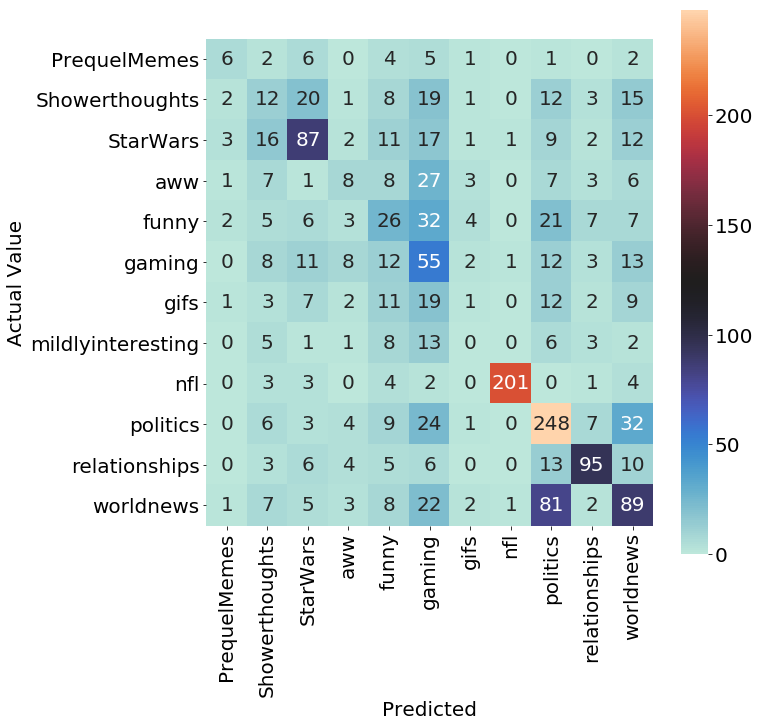

In [10]:
model.fit(trcombostack, y_train)
y_pred = model.predict(tecombostack)
cm = pd.crosstab(y_test, y_pred)

print(sklearn.metrics.accuracy_score(y_test, y_pred))
plotConfusionMatrix(cm)

In [11]:
model = Pipeline(steps=[('TSVD', TruncatedSVD(n_components=5, random_state=0)), ('SVD', SVC(kernel='sigmoid', gamma="auto", C=1E5))])
traintf1 = vectorizer.fit_transform(above50t["body"])
traintf2 = vectorizer2.fit_transform(above50t["author_flair_css_class"])
traintf3 = vectorizer3.fit_transform(above50t["author_flair_text"])
trcombostack = hstack([traintf1, traintf2, traintf3])
scores = cross_validate(model, trcombostack, above50t["subreddit"], cv=5)
print(scores)
print("Test average :",scores["test_score"].mean())

{'fit_time': array([2.04941988, 2.15913987, 2.06757426, 1.89359117, 1.91415548]), 'score_time': array([0.22748542, 0.21525359, 0.24085164, 0.21071887, 0.21062231]), 'test_score': array([0.33230198, 0.33954066, 0.34223602, 0.32981366, 0.33665215]), 'train_score': array([0.33845915, 0.34580165, 0.35226567, 0.33628181, 0.34760354])}
Test average : 0.33610889489458484


<p>Hmmm, Truncated SVD seems to lead to a sharp decrease in accuracy. Raising the n components increases the accuracy, but this seems to be defeating the purpose of using it in the first place. Truncated SVD does not seem to be producing the results I hoped for. Or I'm using it incorrectly.</p>

<a id="apply"></a>
<h2>Applying the best model to the whole corpus [<a href="#toc">TOC</a>]</h2>
<p>This is less than what I wanted, but it's within the final hours. We will apply the best models to the whole corpus again with the discovered features and see how much of an accuracy increase we get from the 11% we got all the way at the beginning.</p>

In [12]:
trainingdata, testingdata, y_train, y_test = train_test_split(above50[["body", "author_flair_css_class","author_flair_text"]], above50["subreddit"], test_size = 1/5, random_state = 0)

In [13]:
traintf1 = vectorizer.fit_transform(trainingdata["body"])
traintf2 = vectorizer2.fit_transform(trainingdata["author_flair_css_class"])
traintf3 = vectorizer3.fit_transform(trainingdata["author_flair_text"])
testtf1 = vectorizer.transform(testingdata["body"])
testtf2 = vectorizer2.transform(testingdata["author_flair_css_class"])
testtf3 = vectorizer3.transform(testingdata["author_flair_text"])

trcombostack = hstack([traintf1, traintf2, traintf3])
tecombostack = hstack([testtf1, testtf2, testtf3])

0.38073068728793497


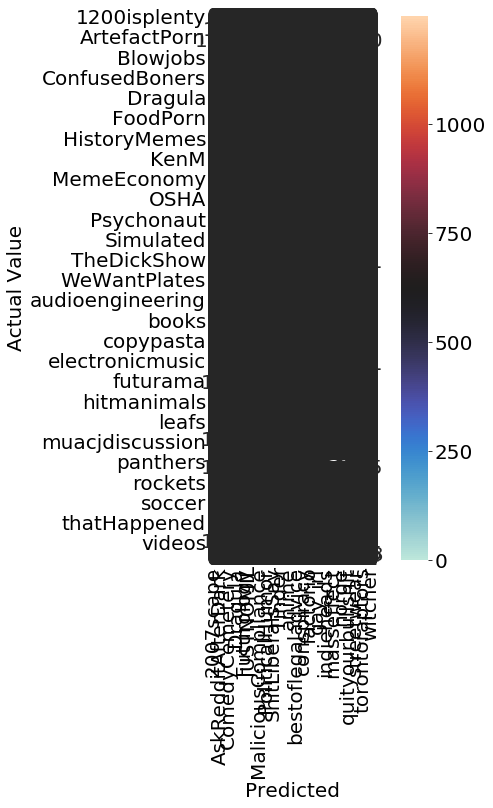

In [14]:
MNB = MultinomialNB(alpha=0.01)
MNB.fit(trcombostack, y_train)
y_pred = MNB.predict(tecombostack)
cm = pd.crosstab(y_test, y_pred)

print(sklearn.metrics.accuracy_score(y_test, y_pred))
plotConfusionMatrix(cm)

<p>We have lept from 11% to 38% after all of this! That was greater than I had anticipated, I thought it would only wind up in the 20-30%. This is incredible. This is still overall low accuracy, but it's a major stepping stone. I'd have loved to have hit 50% though, deep down that was a goal I wanted to hit. Anyway, thank you for following along with the notebooks, hope you enjoyed what you saw (aside from the latest confusion matrix. Still can't get it to display properly).</p>
<h1>The End</h1>